## Import

In [694]:
!pip install statsmodels

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Exploring data

Read raw data from file

In [695]:
file_path = '../data/player_stats.csv'
data = pd.read_csv(file_path)
data.head()

,Unnamed: 0,match_id,game_id,team,score_team,opponent,score_opp,win_lose,map,map_pick,...,rating,acs,kill,death,assist,kast%,adr,hs%,fk,fd
0,0,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,1.19,239,15,11,6,72%,146,16%,1,0
1,1,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.84,234,15,14,6,61%,145,32%,1,4
2,2,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.68,173,10,15,2,67%,123,18%,4,2
3,3,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.63,142,8,15,4,83%,92,29%,3,2
4,4,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.57,114,7,16,8,61%,63,13%,0,1


### How many rows and how many columns?

In [696]:
data.shape

(6230, 23)

### What is the meaning of each row?

Each row contains basic statistics of each player and team for each game in all VCT 2023

### Checking duplicates

In [697]:
num_duplicated_rows = data.duplicated(keep='first').sum()

In [698]:
if num_duplicated_rows == 0:
    print(f"No duplicated lines.")
else:
    ext = "lines" if num_duplicated_rows > 1 else "line"
    print(f"{num_duplicated_rows} duplicated {ext}. De-deduplicating the raw data.")

No duplicated lines.


In [699]:
# De-deduplicate
data = data.drop_duplicates(keep='first')
post_deduplication_count = data.duplicated(keep='first').sum()
assert post_deduplication_count == 0, "Still have duplicated rows after de-duplication."

### What is the meaning of each column?

In [700]:
data.columns

Index(['Unnamed: 0', 'match_id', 'game_id', 'team', 'score_team', 'opponent',
       'score_opp', 'win_lose', 'map', 'map_pick', 'player_id', 'player',
       'agent', 'rating', 'acs', 'kill', 'death', 'assist', 'kast%', 'adr',
       'hs%', 'fk', 'fd'],
      dtype='object')

<table style="width: 100%; border-collapse: collapse;">
  <thead>
    <tr>
      <th style="min-width: 10px; width: 30px; background-color: #AC94F4; color: white; font-size :15px; font-weight: bold; text-align: left; padding: 8px;">STT</th>
      <th style="background-color: #AC94F4; color: white; font-size :15px; font-weight: bold; text-align: left; padding: 8px;">Cột</th>
      <th style="background-color: #AC94F4; color: white; font-size :15px; font-weight: bold; text-align: left; padding: 8px;">Ý nghĩa</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="font-size: 14px; text-align: left;">1</td>
      <td style="font-size: 14px; text-align: left;">match_id</td>
      <td style="font-size: 14px; text-align: left;">ID of matches played</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">2</td>
      <td style="font-size: 14px; text-align: left;">game_id</td>
      <td style="font-size: 14px; text-align: left;">Game ID of each map played from each match</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">3</td>
      <td style="font-size: 14px; text-align: left;">team</td>
      <td style="font-size: 14px; text-align: left;">Team name</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">4</td>
      <td style="font-size: 14px; text-align: left;">score_team</td>
      <td style="font-size: 14px; text-align: left;">Final score achieved by the team</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">5</td>
      <td style="font-size: 14px; text-align: left;">opponent</td>
      <td style="font-size: 14px; text-align: left;">Opponent team name</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">6</td>
      <td style="font-size: 14px; text-align: left;">score_opp</td>
      <td style="font-size: 14px; text-align: left;">Final score achieved by the opponent</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">7</td>
      <td style="font-size: 14px; text-align: left;">win_lose</td>
      <td style="font-size: 14px; text-align: left;">Result of the game</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">8</td>
      <td style="font-size: 14px; text-align: left;">map</td>
      <td style="font-size: 14px; text-align: left;">Name of map played</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">9</td>
      <td style="font-size: 14px; text-align: left;">map_pick</td>
      <td style="font-size: 14px; text-align: left;">Which team picked the map</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">10</td>
      <td style="font-size: 14px; text-align: left;">player_id</td>
      <td style="font-size: 14px; text-align: left;">ID of player</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">11</td>
      <td style="font-size: 14px; text-align: left;">player</td>
      <td style="font-size: 14px; text-align: left;">Player name</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">12</td>
      <td style="font-size: 14px; text-align: left;">agent</td>
      <td style="font-size: 14px; text-align: left;">Agent used in the game</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">13</td>
      <td style="font-size: 14px; text-align: left;">rating</td>
      <td style="font-size: 14px; text-align: left;">Rating by player for the game</td>
    </tr>
     <tr>
      <td style="font-size: 14px; text-align: left;">14</td>
      <td style="font-size: 14px; text-align: left;">acs</td>
      <td style="font-size: 14px; text-align: left;">Average Combat Score</td>
    </tr>
     <tr>
      <td style="font-size: 14px; text-align: left;">15</td>
      <td style="font-size: 14px; text-align: left;">kill</td>
      <td style="font-size: 14px; text-align: left;">Number of Kill Accumulated</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">16</td>
      <td style="font-size: 14px; text-align: left;">death</td>
      <td style="font-size: 14px; text-align: left;">Number of Death Accumulated</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">17</td>
      <td style="font-size: 14px; text-align: left;">assist</td>
      <td style="font-size: 14px; text-align: left;">Number of Assist Accumulated</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">18</td>
      <td style="font-size: 14px; text-align: left;">kast%</td>
      <td style="font-size: 14px; text-align: left;">Percentage of Kill, Assist, Survive, Trade</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">19</td>
      <td style="font-size: 14px; text-align: left;">adr</td>
      <td style="font-size: 14px; text-align: left;">Average damage dealt during a game</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">20</td>
      <td style="font-size: 14px; text-align: left;">hs%</td>
      <td style="font-size: 14px; text-align: left;">Headshot percentage</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">21</td>
      <td style="font-size: 14px; text-align: left;">fk</td>
      <td style="font-size: 14px; text-align: left;">First kill count</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">22</td>
      <td style="font-size: 14px; text-align: left;">fd</td>
      <td style="font-size: 14px; text-align: left;">First death count</td>
    </tr>
  </tbody>
</table>

### Is there any column that isn't needed?

Removing `Unnamed: 0`, `game_id` and `player_id`
- `Unnamed: 0`: index column, not needed
- `game_id`: since `game_id` and `match_id` both represents the id of the match, we only need to keep one
- `player_id`: same for `game_id`, `player` is enough with the existance of `team`

In [701]:
data.drop(columns=['Unnamed: 0', 'game_id', 'player_id'], axis=1, inplace=True)
data.head()

,match_id,team,score_team,opponent,score_opp,win_lose,map,map_pick,player,agent,rating,acs,kill,death,assist,kast%,adr,hs%,fk,fd
0,53658,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,Laz,sova,1.19,239,15,11,6,72%,146,16%,1,0
1,53658,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,TENNN,killjoy,0.84,234,15,14,6,61%,145,32%,1,4
2,53658,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,Dep,jett,0.68,173,10,15,2,67%,123,18%,4,2
3,53658,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,crow,kayo,0.63,142,8,15,4,83%,92,29%,3,2
4,53658,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,SugarZ3ro,omen,0.57,114,7,16,8,61%,63,13%,0,1


### What is the current data type of each column? Are there columns having inappropriate data types?

In [702]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6230 entries, 0 to 6229
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   match_id    6230 non-null   int64 
 1   team        6230 non-null   object
 2   score_team  6230 non-null   int64 
 3   opponent    6230 non-null   object
 4   score_opp   6230 non-null   int64 
 5   win_lose    6230 non-null   object
 6   map         6230 non-null   object
 7   map_pick    6230 non-null   object
 8   player      6230 non-null   object
 9   agent       6230 non-null   object
 10  rating      6230 non-null   object
 11  acs         6230 non-null   object
 12  kill        6230 non-null   int64 
 13  death       6230 non-null   int64 
 14  assist      6230 non-null   int64 
 15  kast%       6230 non-null   object
 16  adr         6230 non-null   object
 17  hs%         6230 non-null   object
 18  fk          6230 non-null   object
 19  fd          6230 non-null   object
dtypes: int64

Need to convert `rating`, `acs`, `kast%`, `adr`, `hs%`, `fk` and `fd` into numerical types.
- For `kast%` and `hs%` we need to remove the % sign and turn it into a fraction (ex 70% is 0.7)

Converting `win_lose` into bool and renaming into `win`, because there is only win or lose, also making it easier for later.
Converting `map_pick` info bool too, same reason.

In [703]:
columns_to_convert = ['rating', 'acs', 'adr', 'fk', 'fd']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')
data['kast%'] = pd.to_numeric(data['kast%'].str.rstrip('%'), errors='coerce') / 100
data['hs%'] = pd.to_numeric(data['hs%'].str.rstrip('%'), errors='coerce') / 100

data['win'] = data['win_lose'].map({'team win': True, 'opponent win': False})
data.drop(columns=['win_lose'], inplace=True)
data['map_pick'] = data['map_pick'].map({'team pick': True, 'opponent pick': False})

In [704]:
data.head()

,match_id,team,score_team,opponent,score_opp,map,map_pick,player,agent,rating,acs,kill,death,assist,kast%,adr,hs%,fk,fd,win
0,53658,ZETA,5,DRX,13,Ascent,False,Laz,sova,1.19,239.0,15,11,6,0.72,146.0,0.16,1.0,0.0,False
1,53658,ZETA,5,DRX,13,Ascent,False,TENNN,killjoy,0.84,234.0,15,14,6,0.61,145.0,0.32,1.0,4.0,False
2,53658,ZETA,5,DRX,13,Ascent,False,Dep,jett,0.68,173.0,10,15,2,0.67,123.0,0.18,4.0,2.0,False
3,53658,ZETA,5,DRX,13,Ascent,False,crow,kayo,0.63,142.0,8,15,4,0.83,92.0,0.29,3.0,2.0,False
4,53658,ZETA,5,DRX,13,Ascent,False,SugarZ3ro,omen,0.57,114.0,7,16,8,0.61,63.0,0.13,0.0,1.0,False


In [705]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6230 entries, 0 to 6229
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   match_id    6230 non-null   int64  
 1   team        6230 non-null   object 
 2   score_team  6230 non-null   int64  
 3   opponent    6230 non-null   object 
 4   score_opp   6230 non-null   int64  
 5   map         6230 non-null   object 
 6   map_pick    6230 non-null   bool   
 7   player      6230 non-null   object 
 8   agent       6230 non-null   object 
 9   rating      6160 non-null   float64
 10  acs         6160 non-null   float64
 11  kill        6230 non-null   int64  
 12  death       6230 non-null   int64  
 13  assist      6230 non-null   int64  
 14  kast%       6160 non-null   float64
 15  adr         6160 non-null   float64
 16  hs%         6160 non-null   float64
 17  fk          6160 non-null   float64
 18  fd          6160 non-null   float64
 19  win         6230 non-null  

### Checking distribution

#### With each numerical column, how are values distributed?

For columns with numeric data types:
- Percentage (from 0 to 100) of missing values
- The min
- The lower quartile (phân vị 25)
- The median (phân vị 50)
- The upper quartile (phân vị 75)
- The max

For viewing, using `.round(1)`.

In [706]:
def numeric_column_info(df: pd.DataFrame) -> pd.DataFrame:
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

    num_col_info = {}
    for col in numeric_columns:
        num_col_info[col] = [
            df[col].isnull().mean() * 100,  # Missing ratio
            df[col].min(),                  # Min
            df[col].quantile(0.25),         # Lower quartile
            df[col].median(),               # Median
            df[col].quantile(0.75),         # Upper quartile
            df[col].max()                   # Max
        ]

    num_col_info_df = pd.DataFrame(num_col_info, index=["missing_ratio", "min", "lower_quartile", "median", "upper_quartile", "max"])

    num_col_info_df = num_col_info_df.round(1)

    return num_col_info_df

In [707]:
num_col_info_df = numeric_column_info(data)
num_col_info_df.head()

,match_id,score_team,score_opp,rating,acs,kill,death,assist,kast%,adr,hs%,fk,fd
missing_ratio,0.0,0.0,0.0,1.1,1.1,0.0,0.0,0.0,1.1,1.1,1.1,1.1,1.1
min,52768.0,0.0,0.0,0.0,36.0,2.0,2.0,0.0,0.1,20.0,0.0,0.0,0.0
lower_quartile,53561.0,8.0,8.0,0.8,158.0,11.0,13.0,4.0,0.6,104.0,0.2,1.0,1.0
median,53699.0,13.0,13.0,1.0,194.0,14.0,15.0,6.0,0.7,127.0,0.2,2.0,2.0
upper_quartile,59969.0,13.0,13.0,1.2,233.0,18.0,17.0,9.0,0.8,153.0,0.3,3.0,3.0


It seems that `rating`, `acs`, `kast%`, `adr`, `hs%`, `fk` and `fd` is missing from some of the matches.
I will check if the values are missing from the same matches, and if yes, i will remove those matches since filling will mess up individual and team performance.

In [708]:
missing_data_columns = ['rating', 'acs', 'kast%', 'adr', 'hs%', 'fk', 'fd']
missing_data = data[missing_data_columns].isnull()
missing_in_all = missing_data.all(axis=1)
matches_with_missing_data = data[missing_in_all]['match_id'].unique()
count_matches_with_missing_data = len(matches_with_missing_data)

if count_matches_with_missing_data > 0:
    data = data[~data['match_id'].isin(matches_with_missing_data)]
else:
    data = data

count_matches_with_missing_data

6

In [709]:
num_col_info_df = numeric_column_info(data)
num_col_info_df.head()

,match_id,score_team,score_opp,rating,acs,kill,death,assist,kast%,adr,hs%,fk,fd
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,52768.0,0.0,0.0,0.0,36.0,2.0,2.0,0.0,0.1,20.0,0.0,0.0,0.0
lower_quartile,53562.0,8.0,8.0,0.8,158.0,11.0,13.0,4.0,0.6,104.0,0.2,1.0,1.0
median,53700.0,13.0,13.0,1.0,194.0,14.0,15.0,6.0,0.7,127.0,0.2,2.0,2.0
upper_quartile,59970.0,13.0,13.0,1.2,233.0,18.0,17.0,9.0,0.8,153.0,0.3,3.0,3.0


A total of 6 matches was removed. Other than that, the data looks fine.

#### With each categorical column, how are values distributed?

For columns with non-numeric data types:
- Percentage (from 0 to 100) of missing values
- Number of values (the values here are different values and we do not consider missing values)
- The percentage (from 0 to 100) of each value is sorted by decreasing percentage (we do not consider missing values, the ratio is the ratio compared to the number of non-missing values)

In [710]:
non_numeric_columns = data.select_dtypes(include=['object', 'bool']).columns

cat_col_info = {}
for col in non_numeric_columns:
    missing_ratio = data[col].isnull().mean() * 100

    num_values = data[col].nunique()

    value_counts = data[col].value_counts(normalize=True) * 100
    value_ratios = value_counts.to_dict()

    cat_col_info[col] = [missing_ratio, num_values, value_ratios]

cat_col_info_df = pd.DataFrame(cat_col_info, index=["missing_ratio", "num_values", "value_ratios"])

cat_col_info_df.loc['missing_ratio'] = cat_col_info_df.loc['missing_ratio'].apply(lambda x: round(x, 1) if isinstance(x, float) else x)

cat_col_info_df

,team,opponent,map,map_pick,player,agent,win
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0
num_values,36,36,8,2,197,21,2
value_ratios,"{'EG': 6.075533661740558, 'PRX': 5.00821018062...","{'EG': 6.075533661740558, 'PRX': 5.00821018062...","{'Ascent': 16.420361247947454, 'Lotus': 16.091...","{False: 57.88177339901478, True: 42.1182266009...","{'Ethan': 1.2151067323481117, 'Boostio': 1.215...","{'killjoy': 12.955665024630541, 'jett': 12.495...","{False: 50.0, True: 50.0}"


Overall, there is no missing value. The data looks fine.

## Asking meaningful questions

### Question 1: How does the choice of agent affect a player's performance metrics across different maps?

#### What is the Question?
We aim to understand if the choice of agent (character) in the game has a significant impact on various performance metrics (like 'rating', 'acs', 'kill', 'death', etc.) of players, and how this impact varies across different maps.

#### Benefits of Finding the Answer:
Strategic Insights for Teams and Players: Understanding how specific agents perform on different maps can help teams and players in strategizing their game plan, including agent selection and map preferences.
Game Balance Analysis: It provides insights into the game's balance, helping to identify if certain agents are overpowered or underperforming on specific maps, which is valuable information for game developers.
Fan and Analyst Utility: Fans and analysts of the game can gain deeper insights into the dynamics of agent-map combinations, enriching their understanding and discussions about the game.

Preprocessing Steps:
Filtering Relevant Data: Focus on columns related to agents, performance metrics, and maps.
Handling Missing Values: Ensure that the data used in the analysis is complete, dealing with any missing values in relevant columns.
Aggregation: Aggregate data by agent and map to analyze performance metrics collectively rather than on an individual match basis.
Analysis Steps:
Statistical Analysis: Perform statistical tests (e.g., ANOVA) to determine if there are significant differences in performance metrics across agents on different maps.
Data Visualization: Create visual representations (like heatmaps or bar charts) to illustrate the performance of each agent on each map.
Interpretation: Analyze the results to draw conclusions about the effectiveness of different agents on different maps.

In [711]:
epsilon = 1e-6  # to avoid division by zero
data['kd_ratio'] = data['kill'] / (data['death'] + epsilon)

# Filter relevant columns
data_filtered = data[['agent', 'map', 'rating', 'acs', 'kd_ratio']]
data_filtered.head()

,agent,map,rating,acs,kd_ratio
0,sova,Ascent,1.19,239.0,1.363636
1,killjoy,Ascent,0.84,234.0,1.071428
2,jett,Ascent,0.68,173.0,0.666667
3,kayo,Ascent,0.63,142.0,0.533333
4,omen,Ascent,0.57,114.0,0.437500


In [712]:
# Group by 'agent' and 'map', and calculate mean and standard deviation for performance metrics
grouped_data = data_filtered.groupby(['agent', 'map']).agg({
    'rating': ['mean', 'std'],
    'acs': ['mean', 'std'],
    'kd_ratio': ['mean', 'std']
}).reset_index()


In [713]:
# Prepare the data for ANOVA
data_anova = data[['agent', 'map', 'rating', 'acs', 'kd_ratio']]

# ANOVA for 'rating' across different agents
model_rating = ols('rating ~ C(agent)', data=data_anova).fit()
anova_table_rating = sm.stats.anova_lm(model_rating, typ=2)
print('ANOVA table for rating across agents:\n', anova_table_rating)

# ANOVA for 'acs' across different agents
model_acs = ols('acs ~ C(agent)', data=data_anova).fit()
anova_table_acs = sm.stats.anova_lm(model_acs, typ=2)
print('\nANOVA table for ACS across agents:\n', anova_table_acs)

# ANOVA for 'kd_ratio' across different agents
model_kd_ratio = ols('kd_ratio ~ C(agent)', data=data_anova).fit()
anova_table_kd_ratio = sm.stats.anova_lm(model_kd_ratio, typ=2)
print('\nANOVA table for K/D Ratio across agents:\n', anova_table_kd_ratio)

ANOVA table for rating across agents:
               sum_sq      df         F        PR(>F)
C(agent)    5.665786    20.0  3.419387  3.700654e-07
Residual  502.804313  6069.0       NaN           NaN

ANOVA table for ACS across agents:
                 sum_sq      df          F         PR(>F)
C(agent)  2.057648e+06    20.0  35.922478  3.748654e-131
Residual  1.738168e+07  6069.0        NaN            NaN

ANOVA table for K/D Ratio across agents:
                sum_sq      df         F        PR(>F)
C(agent)    33.966631    20.0  6.492393  6.925376e-18
Residual  1587.577004  6069.0       NaN           NaN


C:\Users\Hanaki\Documents\Hanaki\DataScience\venv\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


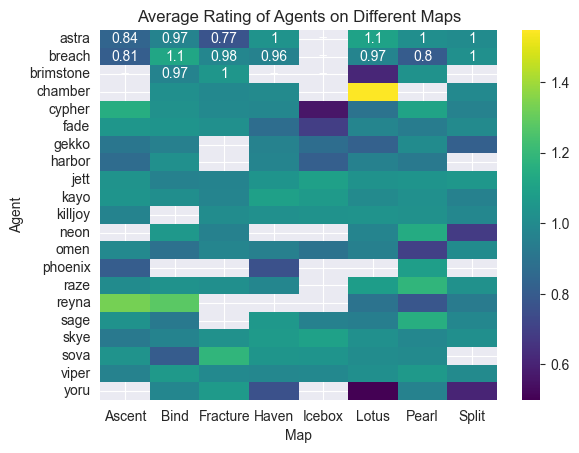

In [714]:
# Visualization of Rating by Agent for each Map using a heatmap
pivot_data = data_filtered.pivot_table(index='agent', columns='map', values='rating', aggfunc='mean')
sns.heatmap(pivot_data, annot=True, cmap='viridis')
plt.title('Average Rating of Agents on Different Maps')
plt.ylabel('Agent')
plt.xlabel('Map')
plt.show()